### Indexes and index sets

* $n \in N$: Set of nodes
* $i \in G$: Set of generators. Each generator is associated with a node $n$.
* $b \in B$: Set of branches
* $b \in B_n^{in}$: Set of branches coming into node $n$
* $b \in B_n^{out}$: Set of branches going out of node $n$
* $t \in T$: Set of time periods
* $i \in G_n$: Set of generators at node $n$
* $d \in T_d$: Set of days
* $d(t)$: T -> T_d, function that maps time periods to day

### Parameters

* $P_{i}^{\min}$: Minimum power output of generator $i$ (MW)
* $P_{i}^{\max}$: Maximum power output of generator $i$ (MW)
* ${VOLL}$: Value of lost load (cost of load shedding) ($/MWh)
* $MC_{i}$: Marginal cost of generator $i$ (\$/MWh)
* $CO2_{i}$ Cost of CO2 emissions of generator $i$ (\$/MWh)
* $E_{i}$: CO2 emissions of generator $i$ (ton/MWh) 
* $E_{limit}$: CO2 emissions limit (ton)
* $D_{n,t}$: Demand at node $n$ and time $t$ (MW)
* $l_b$: loss factor of branch $b$ (given, but in reality some function of distance, transmsission line type, etc.)
* $P_{b}^{\max}$: Maximum power flow on branch $b$ (MW)
* $M$: Big M

### Decision variables
* $g_{i,t}$: Power generation dispatch of generator $i$ at time $t$ (MW)
* $f_{b,t}$: Power flow on branch $b$ at time $t$ (MW)
* $s_{n,t}$: Load shedding at node $n$ at time $t$ (MW)
* $c_{n,t}$: Power curtailment at node $n$ at time $t$ (MW)
* $z_{i,d}$: Binary variable indicating if generator $i$ is active on day d

### Optimization Model

### Objective function, minimize cost of generation

**Minimize:**
$$ \sum_{i \in G} \sum_{t \in T} (MC_i + CO2_i) g_{i,t} + \sum_{n \in N} \sum_{t \in T} s_{n,t} VOLL + \sum_{n \in N} \sum_{t \in T} c_{n,t} CC$$

1. **Power balance: production + inflow - curtailment = outflow + demand - shedding**

*A.K.A. Market clearing or energy balance*

$$ \sum_i (g_{i,t} - c_{i,t}) + \sum_{b \in B_n^{in}} f_{b,t}(1-l_b) - \sum_{b \in B_n^{out}} f_{b,t} + s_{n,t} = D_{n,t} \quad \forall n \in N, \forall t \in T $$

2. **We can't shed more load than the demand**

$$ s_{n,t} \leq D_{n,t} \quad \forall n \in N, \forall t \in T $$

3. **Generators' power output limits**

$$ z_{i,d(t)} P_{i}^{\min} \leq g_{i,t} \leq z_{i,d(t)} P_{i}^{\max} \quad \forall i \in G, \forall t \in T $$

4. **Branch power flow limits**

$$ -P_{b}^{\max} \leq f_{b,t} \leq P_{b}^{\max} \quad \forall b \in B, \forall t \in T $$

5. **Emissions restrictions**

$$ \sum_i \sum_t E_i g_{i,t} \leq E_{limit} $$

6. **Variable definitions**

$$ g_{i,t} \geq 0, \quad f_{b,t} \geq 0, \quad s_{n,t} \geq 0, \quad c_{n,t} \geq 0 \quad \forall i \in G, \forall b \in B, \forall n \in N, \forall t \in T $$

# Basic model implementation

In [1]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import os
import numpy as np
np.random.seed(0)

In [2]:
DATA_FOLDER = os.path.join(os.path.dirname(os.getcwd()), 'data')

In [3]:
branches = pd.read_csv(os.path.join(DATA_FOLDER, 'branches.csv'))
nodes = pd.read_csv(os.path.join(DATA_FOLDER, 'nodes.csv'))
generators = pd.read_csv(os.path.join(DATA_FOLDER, 'generators.csv'))
hourly_demand = pd.read_csv(os.path.join(DATA_FOLDER, 'hourly_demand.csv'))



In [4]:
branch_out_mapping = {node_id: branches[branches["node_from"] == node_id]["branch_id"].values for node_id in nodes['node_id']} 
branch_in_mapping = {node_id: branches[branches["node_to"] == node_id]["branch_id"].values for node_id in nodes['node_id']}
hour_to_day = lambda h: h//24

In [5]:
# Initialize model
model = gp.Model("power_flow_optimization")

# Sets
N = nodes['node_id'].tolist()  # Set of nodes
G = generators['generator_id'].tolist()  # Set of generators
B = branches['branch_id'].tolist()  # Set of branches
T = hourly_demand['hour'].unique().tolist()  # Set of time periods
num_days = len(T) // 24 + 1 if len(T) % 24 != 0 else len(T) // 24  # Number of days in the dataset
hour_to_day_mapping = {hour: hour_to_day(hour) for hour in T} # Mapping from hour to day
T_d = list(range(num_days)) # Set of days


# Parameters
VOLL = 10e3  # Example value for Value of Lost Load (set appropriately)
curtailment_cost = 1e3  # Example value for curtailment cost (set appropriately)
P_min = {row['generator_id']: row['pmin'] for _, row in generators.iterrows()}  # Minimum generation
P_max = {row['generator_id']: row['pmax'] for _, row in generators.iterrows()}  # Maximum generation
MC = {row['generator_id']: row['MC'] for _, row in generators.iterrows()}  # Marginal cost
CO2 = {row['generator_id']: row['CO2'] for _, row in generators.iterrows()}  # CO2 cost
D = {(row['node_id'], row['hour']): row['demand'] for _, row in hourly_demand.iterrows()}  # Demand at node n, time t
E = {row['generator_id']: row['CO2'] for _, row in generators.iterrows()}  # Emissions factor
E_limit = GRB.INFINITY  # Example CO2 emissions limit
P_b_max = {row['branch_id']: row['capacity'] for _, row in branches.iterrows()}  # Branch power flow limits
loss_factor = {row['branch_id']: row['loss_factor'] for _, row in branches.iterrows()}  # Loss factor for each branch

# Decision Variables
g = model.addVars(G, T, lb=0, ub=GRB.INFINITY, name="generation")  # Generation dispatch
f = model.addVars(B, T, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="flow")  # Power flow
s = model.addVars(N, T, lb=0, name="shedding")  # Load shedding
c = model.addVars(N, T, lb=0, name="curtailment")  # Power curtailment
z = model.addVars(G, T_d, vtype=GRB.BINARY, name="generator_usage")

# Objective: Minimize total generation cost (MC + CO2 cost + shed cost)
obj = gp.quicksum((MC[i] + CO2[i]) * g[i, t] for i in G for t in T) + gp.quicksum(VOLL * s[n, t] + curtailment_cost * c[n,t] for n in N for t in T)
model.setObjective(obj, GRB.MINIMIZE)

# Constraint 1: Power balance at each node and time
for n in N:
    for t in T:
        inflow = gp.quicksum(f[b, t] * (1 - loss_factor[b]) for b in branch_in_mapping[n])
        outflow = gp.quicksum(f[b, t] for b in branch_out_mapping[n])
        generation = gp.quicksum(g[i, t] for i in generators[generators['node_id'] == n]['generator_id'])
        curtailment = c[n, t]
        demand = D[n, t]
        model.addConstr(generation - curtailment + inflow - outflow + s[n, t] == demand, f"power_balance_{n}_{t}")

# Constraint 2: Load shedding can't exceed demand
for n in N:
    for t in T:
        model.addConstr(s[n, t] <= D[n, t], f"shedding_limit_{n}_{t}")

# Constraint 3: Generator output limits
for i in G:
    for t in T:
        model.addConstr(g[i, t] >= z[i, hour_to_day_mapping[t]] * P_min[i], f"gen_min_{i}_{t}")
        model.addConstr(g[i, t] <= z[i, hour_to_day_mapping[t]] * P_max[i], f"gen_max_{i}_{t}")

# Constraint 4: Branch power flow limits
for b in B:
    for t in T:
        model.addConstr(f[b, t] <= P_b_max[b], f"branch_max_{b}_{t}")
        model.addConstr(f[b, t] >= -P_b_max[b], f"branch_min_{b}_{t}")

# Constraint 5: CO2 emissions limit
model.addConstr(gp.quicksum(E[i] * g[i, t] for i in G for t in T) <= E_limit, "emissions_limit")

# Optimize the model
model.optimize()

# Extract the results
if model.status == GRB.OPTIMAL:
    generation = model.getAttr('x', g)
    flow = model.getAttr('x', f)
    shedding = model.getAttr('x', s)
    curtailment = model.getAttr('x', c)
    
    # Display results as needed


Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-27
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 3073 rows, 2032 columns and 6048 nonzeros
Model fingerprint: 0x747bcc2d
Variable types: 2016 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [7e-01, 3e+02]
  Objective range  [5e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 1.102804e+08
Presolve removed 2641 rows and 1260 columns
Presolve time: 0.01s
Presolved: 432 rows, 772 columns, 1488 nonzeros
Found heuristic solution: objective 5.536374e+07
Variable types: 768 continuous, 4 

In [6]:
import pandas as pd

# Create empty dictionaries for each result
gen_results = {}
flow_results = {}
shedding_results = {}
curtailment_results = {}

# Extract generation results
for i in G:
    for t in T:
        gen_results[(i, t)] = generation[i, t]

# Extract flow results
for b in B:
    for t in T:
        flow_results[(b, t)] = flow[b, t]

# Extract load shedding results
for n in N:
    for t in T:
        shedding_results[(n, t)] = shedding[n, t]

# Extract curtailment results
for n in N:
    for t in T:
        curtailment_results[(n, t)] = curtailment[n, t]

# Convert results into dataframes for easier analysis
gen_df = pd.DataFrame.from_dict(gen_results, orient='index', columns=['Generation']).reset_index()

# Split the 'index' column (which contains tuples) into two separate columns: 'Generator' and 'Time'
gen_df[['Generator', 'Time']] = pd.DataFrame(gen_df['index'].tolist())
gen_df = gen_df.drop(columns=['index'])
gen_df = gen_df[['Generator', 'Time', 'Generation']]
gen_df.columns = ['Generator', 'Time', 'Generation (MW)']

flow_df = pd.DataFrame.from_dict(flow_results, orient='index', columns=['Flow']).reset_index()
flow_df[['Branch', 'Time']] = pd.DataFrame(flow_df['index'].tolist())
flow_df = flow_df.drop(columns=['index'])
flow_df = flow_df[['Branch', 'Time', 'Flow']]
flow_df.columns = ['Branch', 'Time', 'Flow (MW)']

shedding_df = pd.DataFrame.from_dict(shedding_results, orient='index', columns=['Shedding']).reset_index()
shedding_df[["Node", "Time"]] = pd.DataFrame(shedding_df['index'].tolist())
shedding_df.drop(columns=['index'], inplace=True)
shedding_df = shedding_df[['Node', 'Time', 'Shedding']]
shedding_df.columns = ['Node', 'Time', 'Shedding (MW)']

curtailment_df = pd.DataFrame.from_dict(curtailment_results, orient='index', columns=['Curtailment']).reset_index()
curtailment_df[["Node", "Time"]] = pd.DataFrame(curtailment_df['index'].tolist())
curtailment_df.drop(columns=['index'], inplace=True)
curtailment_df = curtailment_df[['Node', 'Time', 'Curtailment']]
curtailment_df.columns = ['Node', 'Time', 'Curtailment (MW)']




In [19]:
generators

,generator_id,desc,type,pmax,pmin,MC,CO2,node_id
0,0,Solar in A2,solar,76.868661,0.000000,8.793078,0.000000,1
1,1,Oil in A2,oil,126.455561,50.582224,73.227011,0.736845,4
2,2,Oil in A1,oil,132.414101,52.965640,54.490246,0.666696,0
3,3,Coal in A2,coal,289.989998,86.996999,32.261269,1.160939,4
4,4,Coal in A2,coal,330.628007,99.188402,23.418192,0.943261,9
5,5,Solar in A2,solar,66.252361,0.000000,5.192127,0.000000,3
6,6,Solar in A1,solar,82.639516,0.000000,8.175294,0.000000,6
7,7,Solar in A1,solar,62.664580,0.000000,7.331554,0.000000,4


In [7]:
# Total generation per generator
total_generation = gen_df.groupby('Generator')['Generation (MW)'].sum()
print("Total Generation per Generator:\n", total_generation)

# Total load shedding per node
total_shedding = shedding_df.groupby('Node')['Shedding (MW)'].sum()
print("Total Load Shedding per Node:\n", total_shedding)

# Total curtailment per node
total_curtailment = curtailment_df.groupby('Node')['Curtailment (MW)'].sum()
print("Total Curtailment per Node:\n", total_curtailment)


Total Generation per Generator:
 Generator
0    1529.681593
1       0.000000
2       0.000000
3       0.000000
4    5937.993703
5    2900.671793
6    2344.644404
7    2214.440934
Name: Generation (MW), dtype: float64
Total Load Shedding per Node:
 Node
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: Shedding (MW), dtype: float64
Total Curtailment per Node:
 Node
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: Curtailment (MW), dtype: float64


In [8]:
P_min

{0: 0.0,
 1: 50.58222448418508,
 2: 52.96564031172857,
 3: 86.99699939467367,
 4: 99.18840214787626,
 5: 0.0,
 6: 0.0,
 7: 0.0}

In [9]:
P_max

{0: 76.86866147245053,
 1: 126.45556121046268,
 2: 132.41410077932142,
 3: 289.98999798224554,
 4: 330.6280071595875,
 5: 66.25236145041762,
 6: 82.63951585027453,
 7: 62.66458012698911}

In [10]:
# Overall metrics
total_gen = gen_df['Generation (MW)'].sum()
total_shed = shedding_df['Shedding (MW)'].sum()
total_curt = curtailment_df['Curtailment (MW)'].sum()

print(f"Total Generation: {total_gen} MW")
print(f"Total Load Shedding: {total_shed} MW")
print(f"Total Curtailment: {total_curt} MW")

Total Generation: 14927.43242776883 MW
Total Load Shedding: 0.0 MW
Total Curtailment: 0.0 MW


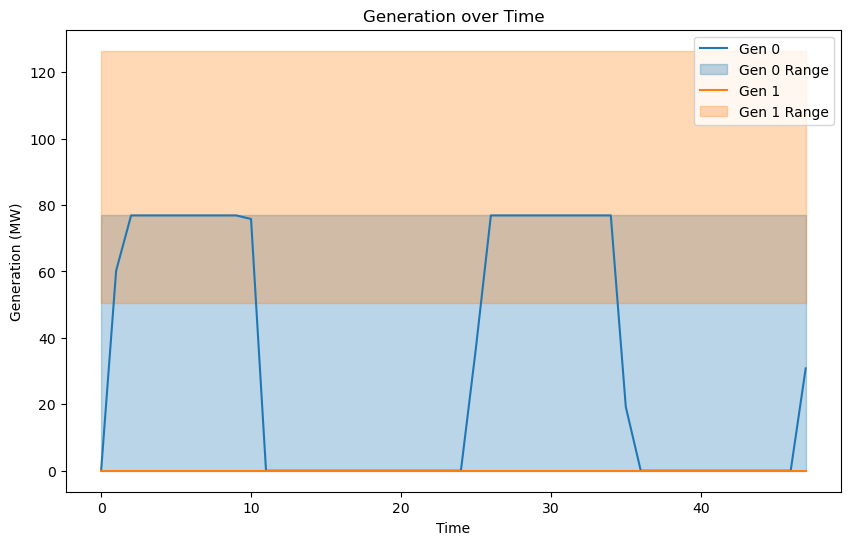

In [11]:
import matplotlib.pyplot as plt

# Plot generation over time for each generator
plt.figure(figsize=(10,6))
for i in G[:2]:
    generator_data = gen_df[gen_df['Generator'] == i]
    time = generator_data['Time']
    generation = generator_data['Generation (MW)']
    p_min = P_min[i]
    p_max = P_max[i]
    line, = plt.plot(time, generation, label=f'Gen {i}')
    
    # Use the same color as the line for the error bar fill
    plt.fill_between(time, p_min, p_max, color=line.get_color(), alpha=0.3, label=f'Gen {i} Range')

plt.title('Generation over Time')
plt.xlabel('Time')
plt.ylabel('Generation (MW)')
plt.legend()
plt.show()




In [12]:
print(gen_df.groupby('Generator')['Generation (MW)'].sum())
gen_df

Generator
0    1529.681593
1       0.000000
2       0.000000
3       0.000000
4    5937.993703
5    2900.671793
6    2344.644404
7    2214.440934
Name: Generation (MW), dtype: float64


,Generator,Time,Generation (MW)
0,0,0,0.000000
1,0,1,60.202731
2,0,2,76.868661
3,0,3,76.868661
4,0,4,76.868661
...,...,...,...
379,7,43,0.000000
380,7,44,17.204061
381,7,45,62.664580
382,7,46,62.664580


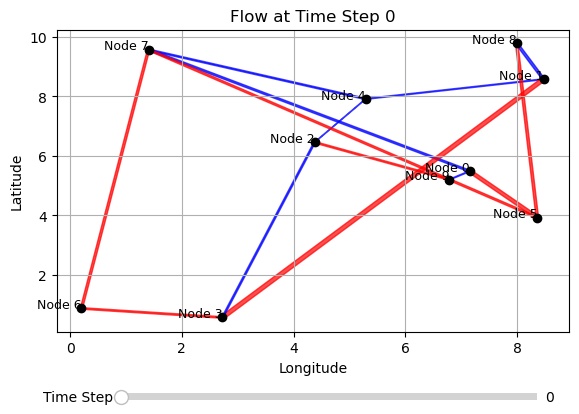

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np

# Scaling factor for flow arrow thickness
scaling_factor = 0.1  # You can set this value
max_flow = np.abs(flow_df['Flow (MW)']).max()
# Function to update the plot for a specific time step
def update_plot(time_step):
    ax.clear()  # Clear the current axes to start fresh
    plot_network(int(time_step))  # Re-plot the network for the given time step
    fig.canvas.draw_idle()  # Redraw the figure to update it

# Function to plot the network at a given time step
def plot_network(time_step):
    for i, row in branches.iterrows():
        node_from = nodes.loc[nodes['node_id'] == row['node_from']].iloc[0]
        node_to = nodes.loc[nodes['node_id'] == row['node_to']].iloc[0]
        
        x_from, y_from = node_from['lon'], node_from['lat']
        x_to, y_to = node_to['lon'], node_to['lat']

        # Get the flow for the current branch at the given time_step
        flow = flow_df[(flow_df['Branch'] == row['branch_id']) & (flow_df['Time'] == time_step)]['Flow (MW)'].values[0]

        # Normalize and scale the thickness of the flow line
        linewidth = np.abs(flow) / max_flow * scaling_factor

        # Set the color based on the direction of the flow (positive or negative)
        color = 'blue' if flow > 0 else 'red'

        # Draw the arrow with the flow direction and thickness
        ax.arrow(x_from, y_from, x_to - x_from, y_to - y_from, 
                 width=linewidth, color=color, length_includes_head=True, 
                 head_width=0.02, alpha=0.7)

    # Plot the nodes as scatter points
    ax.scatter(nodes['lon'], nodes['lat'], color='black', zorder=5)
    
    # Add labels for the nodes
    for i, row in nodes.iterrows():
        ax.text(row['lon'], row['lat'], f"Node {row['node_id']}", fontsize=9, ha='right')

    ax.set_title(f"Flow at Time Step {time_step}")
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)

# Create a figure and axis
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, bottom=0.25)  # Make room for the slider

# Initial plot for time step 0
plot_network(time_step=0)

# Add a slider to control the time step
ax_time = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_time, 'Time Step', 0, flow_df['Time'].max(), valinit=0, valstep=1, dragging=True)

# Update the plot when the slider value changes
slider.on_changed(update_plot)

# Show the plot
plt.show()


In [14]:
# Plot total shedding over time
plt.figure(figsize=(10,6))
plt.plot(shedding_df.groupby('Time')['Shedding (MW)'].sum(), label='Total Load Shedding', color='r')
plt.title('Total Load Shedding over Time')
plt.xlabel('Time')
plt.ylabel('Shedding (MW)')
plt.legend()
plt.show()



<IPython.core.display.Javascript object>

In [15]:
curtailment_df

,Node,Time,Curtailment (MW)
0,0,0,0.0
1,0,1,0.0
2,0,2,0.0
3,0,3,0.0
4,0,4,0.0
...,...,...,...
475,9,43,0.0
476,9,44,0.0
477,9,45,0.0
478,9,46,0.0


In [16]:
# Plot total curtailment over time
plt.figure(figsize=(10,6))
plt.plot(curtailment_df.groupby('Node')['Curtailment (MW)'].sum(), label='Total Curtailment', color='g')
plt.title('Total Curtailment per node')
plt.xlabel('Node')
plt.ylabel('Curtailment (MW)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>